In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
data = {}
pillars = ["busi", "econ", "educ", "envi", "gove", "heal", "pers", "safe", "soci"]
for i in pillars:
    train_df = pd.read_csv("data/{0}_train.csv".format(i)).drop("Unnamed: 0", axis = 1)
    test_df = pd.read_csv("data/{0}_test.csv".format(i)).drop("Unnamed: 0", axis = 1)
    data[i] = {"test" : test_df, "train" : train_df}

In [2]:
score_table = pd.read_csv("data/scores.csv")
prosperity_table = score_table[["country","year","prosperity"]]
# Most prosperous country and year
prosperity_table.sort_values("prosperity", ascending=False).head(5)

,country,year,prosperity
1149,New Zealand,2014,78.914742
1000,New Zealand,2013,78.832643
576,Sweden,2010,78.657402
1147,Norway,2014,78.500937
725,Sweden,2011,78.487949


In [3]:
score_table["most_impact"] = score_table[pillars].sub(score_table["prosperity"],axis=0).iloc[:,:-1].abs().T.idxmax()
score_table.head()

,Unnamed: 0,country,year,busi,econ,educ,envi,gove,heal,pers,safe,soci,prosperity,most_impact
0,0,Afghanistan,2007,35.308167,53.251713,22.494400,39.293343,29.760307,51.600807,32.290104,37.240280,37.691658,37.658975,econ
1,1,Angola,2007,27.057371,51.743580,35.916668,47.982162,30.910105,57.914005,45.123459,53.325123,44.954544,43.880780,busi
2,2,Albania,2007,40.626377,57.979511,56.318413,51.049442,42.531654,74.527748,60.275913,68.989883,41.740612,54.893284,heal
3,3,United Arab Emirates,2007,52.791740,67.167816,59.942955,62.051479,48.831993,77.575127,49.087570,80.370224,52.181824,61.111192,safe
4,4,Argentina,2007,47.438419,62.476505,51.995552,64.909729,45.032742,74.439102,63.805622,68.519714,48.400772,58.557573,heal


In [4]:
pillar_table = pd.pivot_table(
    score_table[["country","year","most_impact"]],
    values="most_impact",index="country",
    columns="year", aggfunc="first")
pillar_table.head()

year,2007,2008,2009,2010,2011,2012,2013,2014
country,,,,,,,,
Afghanistan,econ,econ,econ,heal,heal,heal,heal,heal
Albania,heal,heal,heal,heal,heal,heal,heal,heal
Algeria,heal,heal,heal,heal,heal,heal,heal,heal
Angola,busi,busi,busi,busi,busi,heal,heal,heal
Argentina,heal,heal,heal,pers,pers,pers,pers,pers


In [5]:
most_important_pillars = pillar_table.mode(axis=1).iloc[:,0]
most_important_pillars

country
Afghanistan    heal
Albania        heal
Algeria        heal
Angola         busi
Argentina      pers
               ... 
Venezuela      gove
Vietnam        pers
Yemen          heal
Zambia         educ
Zimbabwe       gove
Name: 0, Length: 149, dtype: object

In [6]:
top_growth = ["Togo","Zimbabwe","Chad","Georgia","Macedonia"]
most_important_pillars.loc[top_growth[:5]]

country
Togo         safe
Zimbabwe     gove
Chad         educ
Georgia      heal
Macedonia    safe
Name: 0, dtype: object

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_classification

In [39]:
for i in pillars: 
    columns = [col for col in data[i]['train'].columns if col[-4:]!="year" and col[:4]!="rank" and col not in ["country","isonum","isocode"]]
    tmpX = data[i]['train'][columns].select_dtypes(np.number)
    rank = "rank_" + i 
    # tmpX = tmpX.drop(columns = [rank])
    tmpX = tmpX.drop(columns = [i])
    tmpy = data[i]['train'][i]
    
    # ohotyr = pd.get_dummies(tmpX['year'])
    # tmpX = tmpX.drop(columns = ['year'])
    
    mod = LinearRegression()
    mod.fit(tmpX, tmpy)
    impt = mod.coef_
    
    tmp_coeff = pd.DataFrame([tmpX.columns, np.absolute(impt)]).T.sort_values(1, ascending=False)
    tp3 = tmp_coeff.iloc[:3]
    # important_categories
    print("Most Impactful Categories on " + i + "\n", tp3.values)

Most Impactful Categories on busi
 [['ippr' 2.4785666187535074]
 ['logis' 2.0406800839176795]
 ['affs' 2.0249854499059343]]
Most Impactful Categories on econ
 [['gdp5' 18.61007125605273]
 ['eqi' 5.717482698722488]
 ['amp' 2.674101549294211]]
Most Impactful Categories on educ
 [['gbrata' 17.24460175621022]
 ['Ginih15' 13.976619531601534]
 ['qslnl' 1.714573675931544]]
Most Impactful Categories on envi
 [['airpollution' 18.58170121136535]
 ['pestreg' 0.3752748037874074]
 ['improved_drinkwater' 0.2240982761674628]]
Most Impactful Categories on gove
 [['womenparl' 7.635881449139032]
 ['rlaw' 2.6329439616734844]
 ['geff' 2.5375353055530114]]
Most Impactful Categories on heal
 [['meandiabetes' 0.4445602540596016]
 ['tblnl' 0.2586987768556513]
 ['leb' 0.25317393609735805]]
Most Impactful Categories on pers
 [['deathpen' 7.695642652806546]
 ['propright' 6.759789892417538]
 ['lgbt_rights' 4.2851478904825955]]
Most Impactful Categories on safe
 [['homilnl' 3.5079094016718875]
 ['pts' 3.0694309984

In [9]:
X = pd.concat([
    data["busi"]["test"][["ippr","logis",'affs',"bband","redu","elcostlnl"]],
    data["econ"]["test"][["gdp5","eqi","amp","povdday","urate","edi"]],
    data["educ"]["test"][["qslnl","teryrs","secyrs","edqualsc","Ginih15","gbrata"]],
    data["envi"]["test"][["pestreg","improved_drinkwater","terrestprotect","fwateruse","fishstock","airpollution"]],
    data["gove"]["test"][["womenparl","rlaw","geff","ticpi","vapvt","rqual"]],
    data["heal"]["test"][["leb","impsan","imeas","Obesity","tblnl","meandiabetes"]],
    data["pers"]["test"][["propright","lgbt_rights","civlib","rrgov","rrsoc","deathpen"]],
    data["safe"]["test"][["tdeathslnl5","bdeathslnl","refugee_oriln","warcasual","pts","homilnl"]],
    data["soci"]["test"][["vtf"]]
],axis=1)
X.head()

,ippr,logis,affs,bband,redu,elcostlnl,gdp5,eqi,amp,povdday,...,rrgov,rrsoc,deathpen,tdeathslnl5,bdeathslnl,refugee_oriln,warcasual,pts,homilnl,vtf
0,2.457773,2.069573,3.852955,0.004795,26.472107,8.151823,0.029082,0.715496,3.438251,20.203930,...,8.0,7.8,1,8.180225,5.276663,11.330479,3.0,4.666667,1.864207,20.623501
1,2.257915,2.542980,3.236488,0.412784,31.007937,6.421622,0.017570,0.434404,2.034871,30.129999,...,5.0,2.9,0,-0.693147,-4.298536,6.084814,0.0,3.666667,2.383776,25.100000
2,2.896221,2.770000,3.737438,6.573716,20.825397,6.197258,0.027832,0.889969,3.392698,1.060000,...,2.2,0.3,0,-0.415888,-4.298536,8.154903,0.0,2.000000,1.393474,50.644501
3,5.475348,3.539098,5.424749,11.558400,4.285714,3.157000,0.017219,0.770421,5.295191,0.023814,...,4.6,1.5,1,-0.415888,-4.298536,2.298153,0.0,2.666667,-0.488302,0.000000
4,2.424609,2.986475,2.923875,15.573113,30.333333,3.214868,0.014131,0.776706,3.031993,1.750000,...,2.0,1.4,0,-0.693147,-4.298536,2.210600,0.0,2.666667,1.950704,77.016499


In [52]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import VAR

togo_data = score_table[score_table["country"] == "Togo"][pillars]
togo_ser = togo_data.diff().dropna()

var_model = VAR(togo_ser)
var_model_fit = var_model.fit()
togo_predicted = var_model_fit.forecast(var_model_fit.y,steps=2)
togo_predicted

/root/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/root/venv/lib/python3.7/site-packages/statsmodels/base/wrapper.py:34: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


array([[ 3.18083764,  0.32874624, -0.33759081, -0.95255653, -0.58467637,
         0.5081421 , -4.02200967,  2.09585619,  4.31650698],
       [-0.03987409, -0.21141693, -2.48423932, -2.32056064, -3.74720778,
         0.38513551, -8.22298901,  6.5242377 ,  1.83961661]])

In [48]:
togo_data.mean(axis=1)

132     40.598943
281     40.428445
430     41.008301
579     42.251967
728     44.807551
877     45.099571
1026    45.689325
1175    47.286801
dtype: float64

In [49]:
(togo_data.iloc[-1] + togo_predicted[0]).mean()

47.790495893827455

Text(0.5, 1.0, 'Prosperity Score of Togo')

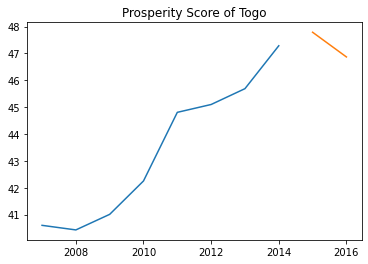

In [50]:
plt.plot([i for i in range(2007,2015)], list(togo_data.mean(axis=1)))
plt.plot([2015,2016], 
[(togo_data.iloc[-1] + togo_predicted[0]).mean(), 
(togo_data.iloc[-1] + togo_predicted[0] + togo_predicted[1]).mean()])
plt.title("Prosperity Score of Togo")

In [13]:
y_lst = [data["busi"]["train"][["country","year"]]]

for pillar in pillars:
    y_lst.append(data[pillar]["train"][[pillar,"rank_" + pillar]])
y = pd.concat(y_lst, axis=1)
y.head()

,country,year,busi,rank_busi,econ,rank_econ,educ,rank_educ,envi,rank_envi,gove,rank_gove,heal,rank_heal,pers,rank_pers,safe,rank_safe,soci,rank_soci
0,Afghanistan,2007,35.308167,127,53.251713,115,22.494400,143,39.293343,146,29.760307,142,51.600807,140,32.290104,142,37.240280,149,37.691658,144
1,Angola,2007,27.057371,146,51.743580,125,35.916668,125,47.982162,137,30.910105,137,57.914005,123,45.123459,113,53.325123,137,44.954544,107
2,Albania,2007,40.626377,107,57.979511,88,56.318413,72,51.049442,119,42.531654,91,74.527748,45,60.275913,68,68.989883,61,41.740612,124
3,United Arab Emirates,2007,52.791740,42,67.167816,43,59.942955,52,62.051479,50,48.831993,59,77.575127,34,49.087570,106,80.370224,16,52.181824,51
4,Argentina,2007,47.438419,68,62.476505,61,51.995552,92,64.909729,33,45.032742,84,74.439102,48,63.805622,55,68.519714,65,48.400772,78


In [14]:
feature_columns = ["year", 'ippr', 'logis', 'affs', 'bband', 'redu',
       'elcostlnl', 'gdp5', 'eqi', 'amp', 'povdday', 'urate', 'edi', 'qslnl',
       'teryrs', 'secyrs', 'edqualsc', 'Ginih15', 'gbrata', 'pestreg',
       'improved_drinkwater', 'terrestprotect', 'fwateruse', 'fishstock',
       'airpollution', 'womenparl', 'rlaw', 'geff', 'ticpi', 'vapvt', 'rqual',
       'leb', 'impsan', 'imeas', 'Obesity', 'tblnl', 'meandiabetes',
       'propright', 'lgbt_rights', 'civlib', 'rrgov', 'rrsoc', 'deathpen',
       'tdeathslnl5', 'bdeathslnl', 'refugee_oriln', 'warcasual', 'pts',
       'homilnl', 'vtf']

In [15]:
from sklearn.model_selection import train_test_split

train_X = pd.read_csv("data/merged_train.csv")[feature_columns]
# train_y = y.iloc[:,2:]
train_y = score_table[pillars]
test_X = pd.read_csv("data/merged_test.csv")[feature_columns]

train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.33)
print("train_X: ", train_X.shape, ", train_y: ", train_y.shape)
print("val_X: ", val_X.shape, ", val_y: ", val_y.shape)

train_X:  (798, 50) , train_y:  (798, 9)
val_X:  (394, 50) , val_y:  (394, 9)


In [16]:
lr_model = LinearRegression()
lr_model.fit(train_X, train_y)
lr_model.score(val_X,val_y)

0.9246189690834746

In [17]:
lr_model.predict(test_X)

array([[38.09382099, 51.18611744, 26.00395506, ..., 21.53427206,
        40.13357182, 38.97790307],
       [37.64407703, 50.13205634, 30.6172052 , ..., 46.30804399,
        58.93048538, 45.43188219],
       [50.97726264, 59.43825506, 59.05743179, ..., 64.96165362,
        67.91917194, 45.63305253],
       ...,
       [62.65471018, 56.44797157, 55.87053138, ..., 81.894171  ,
        57.65482453, 56.85383064],
       [48.74124304, 51.4997598 , 41.27907908, ..., 51.67266732,
        60.62091596, 52.97814118],
       [41.69971317, 55.32175587, 49.39971263, ..., 47.43957878,
        57.5508069 , 48.03789726]])

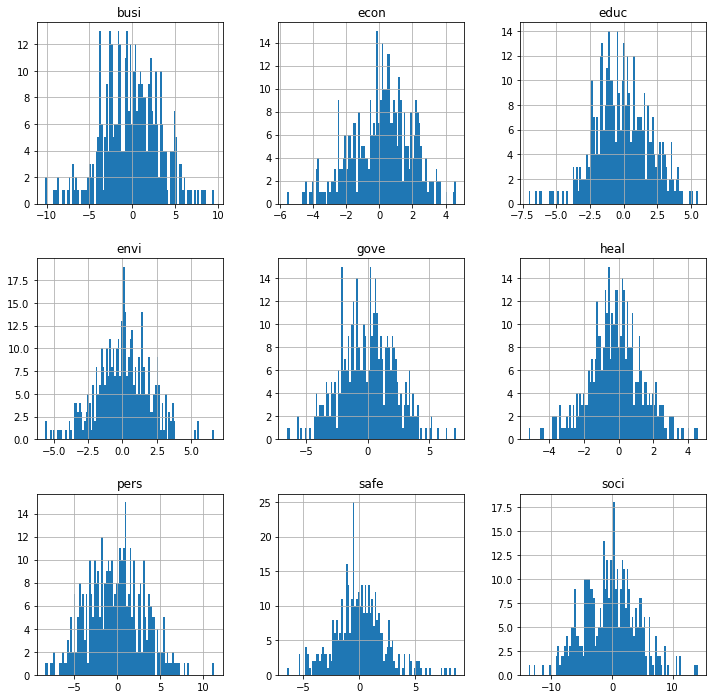

In [18]:
residual_df = (lr_model.predict(val_X) - val_y)[pillars]

fig, axes = plt.subplots(len(residual_df.columns)//3, 3, figsize=(12, 12))

i = 0
for triaxis in axes:
    for axis in triaxis:
        residual_df.hist(column = residual_df.columns[i], bins = 100, ax=axis)
        i = i+1

In [19]:
from sklearn import svm
from sklearn.multioutput import MultiOutputRegressor

# Create the Multioutput Regressor
muti_svr = MultiOutputRegressor(svm.SVR())
muti_svr.fit(train_X,train_y)
muti_svr.score(val_X,val_y)

0.22307776826600678

In [20]:
from sklearn.ensemble import RandomForestRegressor

rf_regr = RandomForestRegressor()
rf_regr.fit(train_X,train_y)
rf_regr.score(val_X,val_y)

0.9599743440101562

In [21]:
from sklearn.decomposition import PCA

n_lst = list(range(5, 50, 2))
lr_scores, rf_scores = [], []
for n in n_lst:
    print("Components:", n)
    pca = PCA(n_components=n)
    train_X_pca = pca.fit_transform(train_X)
    val_X_pca = pca.transform(val_X)

    lr_model = LinearRegression()
    lr_model.fit(train_X_pca, train_y)
    lr_score = lr_model.score(val_X_pca,val_y)
    #print("Linear Regression after PCA: ", lr_score)
    lr_scores.append(lr_score)

    rf_regr = RandomForestRegressor()
    rf_regr.fit(train_X_pca,train_y)
    rf_score = rf_regr.score(val_X_pca,val_y)
    #print("Random Forest after PCA: ", rf_score)
    rf_scores.append(rf_score)

Components: 5
Components: 7
Components: 9
Components: 11
Components: 13
Components: 15
Components: 17
Components: 19
Components: 21
Components: 23
Components: 25
Components: 27
Components: 29
Components: 31
Components: 33
Components: 35
Components: 37
Components: 39
Components: 41
Components: 43
Components: 45
Components: 47
Components: 49


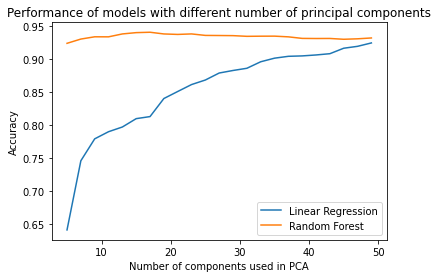

In [97]:
plt.figure(facecolor='white')
plt.plot(n_lst, lr_scores, label="Linear Regression")
plt.plot(n_lst, rf_scores, label="Random Forest")
plt.legend()
plt.xlabel("Number of components used in PCA")
plt.ylabel("Accuracy")
plt.title("Performance of models with different number of principal components")
plt.savefig("images/pca_plot.png",facecolor=fig.get_facecolor(),edgecolor='none')

In [23]:
print("Best PCA n = ",n_lst[np.argmax(rf_scores)])
print("Best Accuracy with Random Forest: ",rf_scores[np.argmax(rf_scores)])

Best PCA n =  17
Best Accuracy with Random Forest:  0.9404464779663684


In [24]:
# pca = PCA(n_components=15)
# train_X_pca = pca.fit_transform(train_X)
# val_X_pca = pca.transform(val_X)

# best_regr = RandomForestRegressor()
# best_regr.fit(train_X_pca,train_y)
# best_score = best_regr.score(val_X_pca,val_y)
# best_score

rf_regr = RandomForestRegressor()
rf_regr.fit(train_X,train_y)
rf_regr.score(val_X,val_y)

0.962013481692119

In [25]:
top_growth = top_growth[:5]
top_growth

['Togo', 'Zimbabwe', 'Chad', 'Georgia', 'Macedonia']

In [69]:
# test_X = pd.read_csv("merged_test.csv")[feature_columns]
raw_test = pd.read_csv("data/merged_test.csv")
togo_X = raw_test[raw_test["country"] == "Togo"][feature_columns]
rf_regr.predict(togo_X)

array([[40.18395639, 50.01771572, 31.92911963, 58.10699299, 35.84083681,
        53.80361168, 55.88599583, 58.7379837 , 34.75551064],
       [40.18395639, 50.01771572, 31.92911963, 58.10699299, 35.84083681,
        53.80361168, 55.88599583, 58.7379837 , 34.75551064]])

In [86]:
test_15 = raw_test[raw_test["year"]==2015][feature_columns].iloc[:,1:].to_numpy()
test_16 = raw_test[raw_test["year"]==2016][feature_columns].iloc[:,1:].to_numpy()
test_15[test_15 == test_16]

array([ 2.45777297,  2.06957293,  3.85295463, ...,  3.        ,
        2.01900196, 28.56700134])

In [87]:
test_16[test_15 == test_16]

array([ 2.45777297,  2.06957293,  3.85295463, ...,  3.        ,
        2.01900196, 28.56700134])

In [ ]:
raw_test[raw_test["year"]==2016][feature_columns].iloc[:,1:].to_numpy()

In [73]:
raw_test[raw_test["country"] == "Rwanda"]

,Unnamed: 0,country,isonum,isocode,year,logis,bband,redu,hifi,affs,...,civlib,conscription,pf,warcasual,pts,tdeathslnl5,refugee_oriln,bdeathslnl,rdeathslnl,homilnl
118,118,Rwanda,646,RWA,2015,2.759116,0.024107,12.952381,4.306888,4.257961,...,2,10.0,79.0,0.0,3.333333,0.957498,8.932852,-4.298536,3.063795,1.529082
267,267,Rwanda,646,RWA,2016,2.759116,0.024107,12.952381,4.306888,4.257961,...,2,10.0,79.0,0.0,3.333333,0.818869,8.932852,-4.298536,3.063795,1.529082


In [75]:
# pd.read_csv("data/merged_train.csv")[feature_columns]
pd.read_csv("data/merged_train.csv")[pd.read_csv("data/merged_train.csv")["country"] == "Togo"][feature_columns]

,year,ippr,logis,affs,bband,redu,elcostlnl,gdp5,eqi,amp,...,rrgov,rrsoc,deathpen,tdeathslnl5,bdeathslnl,refugee_oriln,warcasual,pts,homilnl,vtf
132,2007,3.069371,2.25000,3.40147,0.020583,18.70186,8.778341,0.000646,0.709262,3.626827,...,2.8,0.0,1,-0.693147,-4.298536,8.248034,0.0,3.0,2.241961,25.476000
281,2008,3.069371,2.25000,3.40147,0.031917,18.70186,8.778341,0.000646,0.735686,3.626827,...,0.9,0.0,1,-0.693147,-4.298536,7.925610,0.0,2.5,2.241961,25.476000
430,2009,3.069371,2.25000,3.40147,0.067801,18.70186,8.778341,0.000646,0.791452,3.626827,...,1.2,0.0,1,-0.693147,-4.298536,7.991178,0.0,2.5,2.241961,25.476000
579,2010,3.069371,2.60000,3.40147,0.431731,18.70186,8.702959,0.000646,0.759587,3.626827,...,1.4,0.3,0,-0.693147,-4.298536,7.961427,0.0,2.5,2.241961,33.967999
728,2011,3.069371,2.60000,3.40147,0.525918,18.70186,8.703374,0.001632,0.759587,3.626827,...,1.7,0.3,0,-0.693147,-4.298536,7.909002,0.0,3.0,2.241961,33.967999
877,2012,3.069371,2.58000,3.40147,0.624619,18.70186,8.637409,0.014542,0.759587,3.626827,...,1.7,0.3,0,-0.693147,-4.298536,7.752082,0.0,2.5,2.241961,33.967999
1026,2013,3.069371,2.58000,3.40147,0.101438,18.70186,8.684604,0.020229,0.759587,3.626827,...,1.5,0.0,0,-0.693147,-4.298536,7.308777,0.0,1.0,2.241961,26.424000
1175,2014,3.069371,2.31846,3.40147,0.180317,18.70186,8.624701,0.023073,0.759587,3.626827,...,1.5,0.0,0,-0.693147,-4.298536,7.308777,0.0,1.5,2.241961,26.424000


In [72]:
pd.read_csv("./data/raw/busi_test.csv")[pd.read_csv("./data/raw/busi_test.csv")["country"] == "Togo"]

,Unnamed: 0,country,isonum,isocode,year,start,start_year,ahead,ahead_year,logis,...,ippr,ippr_year,insdtf,insdtf_year,creddtf,creddtf_year,elcostlnl,elcostlnl_year,stardtf,stardtf_year
132,1324,Togo,768,TGO,2015,***,2015,***,2015,2.31846,...,3.069371,--,43.12,2015,30.0,2015,8.649116,2015,78.37,2015
281,1473,Togo,768,TGO,2016,***,2015,***,2015,2.31846,...,3.069371,--,43.12,2015,30.0,2015,8.649116,2015,78.37,2015


In [27]:
rf_regr.predict(togo_X).mean(axis=1)

array([46.58463593, 46.58463593])

Text(0.5, 1.0, 'Prosperity Score of Togo')

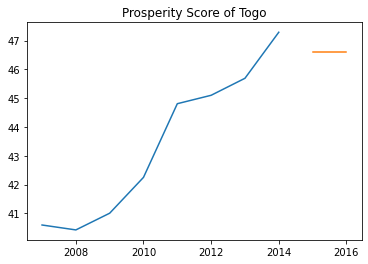

In [28]:
plt.plot([i for i in range(2007,2015)], list(score_table[score_table["country"]=="Togo"]["prosperity"]))
plt.plot([2015,2016], list(rf_regr.predict(togo_X).mean(axis=1)))
plt.title("Prosperity Score of Togo")

/root/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/root/venv/lib/python3.7/site-packages/statsmodels/base/wrapper.py:34: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Text(0.5, 1.0, 'Prosperity Score of Togo')

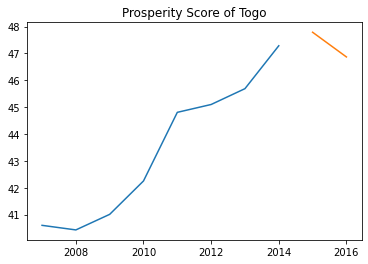

In [53]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import VAR

togo_data = score_table[score_table["country"] == "Togo"][pillars]
togo_ser = togo_data.diff().dropna()

var_model = VAR(togo_ser)
var_model_fit = var_model.fit()
togo_predicted = var_model_fit.forecast(var_model_fit.y,steps=2)

plt.plot([i for i in range(2007,2015)], list(togo_data.mean(axis=1)))
plt.plot([2015,2016], 
[(togo_data.iloc[-1] + togo_predicted[0]).mean(), 
(togo_data.iloc[-1] + togo_predicted[0] + togo_predicted[1]).mean()])
plt.title("Prosperity Score of Togo")

/root/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/root/venv/lib/python3.7/site-packages/statsmodels/base/wrapper.py:34: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)
/root/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/root/venv/lib/python3.7/site-packages/statsmodels/base/wrapper.py:34: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)
/root/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.

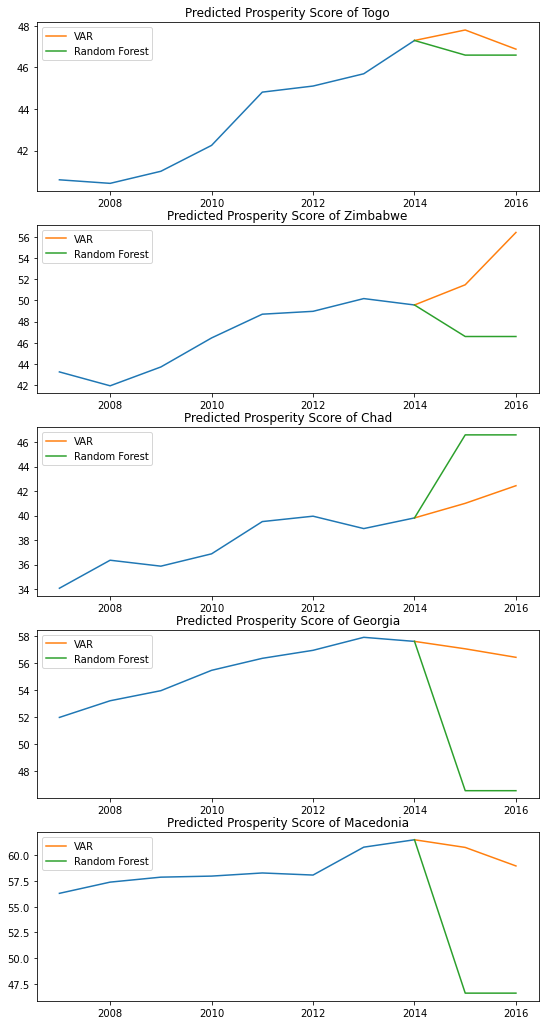

In [95]:
fig, axes = plt.subplots(len(top_growth),figsize=(9,18),facecolor='white')

for i in range(len(top_growth)):
    country = top_growth[i]
    togo_data = score_table[score_table["country"] == country][pillars]
    togo_ser = togo_data.diff().dropna()
    # VAR Predictions
    var_model = VAR(togo_ser)
    var_model_fit = var_model.fit()
    togo_predicted = var_model_fit.forecast(var_model_fit.y,steps=2)
    # Random Forest Predictions
    togo_X = raw_test[raw_test["country"] == "Togo"][feature_columns]
    rf_pred = list(rf_regr.predict(togo_X).mean(axis=1))

    input_values = list(togo_data.mean(axis=1))
    var_pred = [(togo_data.iloc[-1] + togo_predicted[0]).mean(), 
    (togo_data.iloc[-1] + togo_predicted[0] + togo_predicted[1]).mean()]

    axes[i].plot([i for i in range(2007,2015)], input_values)
    axes[i].plot([2014,2015,2016], [input_values[-1]] + var_pred, label="VAR")
    axes[i].plot([2014,2015,2016], [input_values[-1]] + rf_pred, label="Random Forest")
    axes[i].legend()
    axes[i].set_title("Predicted Prosperity Score of {}".format(country))
fig.savefig("./images/forecasts.png",facecolor=fig.get_facecolor(),edgecolor='none')

In [99]:
len(score_table["country"].unique())

149

In [119]:
countries = score_table["country"].unique()
data_arr = []

for i in range(len(countries)):
    country = countries[i]
    togo_data = score_table[score_table["country"] == country][pillars]
    togo_ser = togo_data.diff().dropna()
    # VAR Predictions
    var_model = VAR(togo_ser)
    var_model_fit = var_model.fit()
    togo_predicted = var_model_fit.forecast(var_model_fit.y,steps=2)
    # print(togo_data.to_numpy())

    data_arr.append(np.concatenate((togo_data.to_numpy(),
    [(togo_data.iloc[-1] + togo_predicted[0]), 
    (togo_data.iloc[-1] + togo_predicted[0] + togo_predicted[1])])))

/root/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/root/venv/lib/python3.7/site-packages/statsmodels/base/wrapper.py:34: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)
/root/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/root/venv/lib/python3.7/site-packages/statsmodels/base/wrapper.py:34: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)
/root/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.

In [125]:
data_arr = np.array(data_arr)

In [124]:
[(i, countries[i]) for i in range(len(countries)) if countries[i] in top_growth]

[(49, 'Georgia'),
 (89, 'Macedonia'),
 (131, 'Chad'),
 (132, 'Togo'),
 (148, 'Zimbabwe')]

In [139]:
def get_ranks(array):
    temp = array.argsort()
    ranks = np.empty_like(temp)
    ranks[temp] = np.arange(len(array))
    return ranks

(149,)

In [149]:
# Rank
data_15 = {}
data_16 = {}
rank_15 = {}
rank_16 = {}

for i in range(len(pillars)):
    data_15[pillars[i]] = data_arr[:,-2,i]
    data_16[pillars[i]] = data_arr[:,-1,i]
    rank_15[pillars[i]] = get_ranks(data_arr[:,-2,i])
    rank_16[pillars[i]] = get_ranks(data_arr[:,-1,i])

In [158]:
import collections

df_15 =collections.defaultdict(list)
df_16 =collections.defaultdict(list)

for idx, country in [(i, countries[i]) for i in range(len(countries)) if countries[i] in top_growth]:
    print("Country: ", country)
    df_15["country"].append(country)
    df_16["country"].append(country)
    for pillar in pillars:
        df_15[pillar].append(data_15[pillar][idx])
        df_15["rank_" + pillar].append(rank_15[pillar][idx])
        df_16[pillar].append(data_16[pillar][idx])
        df_16["rank_" + pillar].append(rank_16[pillar][idx])

Country:  Georgia
Country:  Macedonia
Country:  Chad
Country:  Togo
Country:  Zimbabwe


In [175]:
result_15 = pd.DataFrame(df_15) 
print(result_15.to_markdown())

|    | country   |    busi |   rank_busi |    econ |   rank_econ |    educ |   rank_educ |    envi |   rank_envi |    gove |   rank_gove |    heal |   rank_heal |    pers |   rank_pers |    safe |   rank_safe |    soci |   rank_soci |
|---:|:----------|--------:|------------:|--------:|------------:|--------:|------------:|--------:|------------:|--------:|------------:|--------:|------------:|--------:|------------:|--------:|------------:|--------:|------------:|
|  0 | Georgia   | 52.9735 |          79 | 59.9654 |          61 | 59.1949 |          85 | 53.4916 |          28 | 54.0779 |          98 | 65.9174 |          46 | 56.0263 |          71 | 66.28   |          76 | 45.3822 |          48 |
|  1 | Macedonia | 55.536  |          88 | 59.253  |          56 | 66.4805 |         120 | 64.9589 |          94 | 51.2761 |          88 | 72.848  |          84 | 55.64   |          70 | 76.0674 |         114 | 45.0173 |          44 |
|  2 | Chad      | 39.7406 |          14 | 45.7739 |        

In [176]:
result_16 = pd.DataFrame(df_16)
print(result_16.to_markdown())

|    | country   |    busi |   rank_busi |    econ |   rank_econ |    educ |   rank_educ |    envi |   rank_envi |    gove |   rank_gove |    heal |   rank_heal |    pers |   rank_pers |    safe |   rank_safe |    soci |   rank_soci |
|---:|:----------|--------:|------------:|--------:|------------:|--------:|------------:|--------:|------------:|--------:|------------:|--------:|------------:|--------:|------------:|--------:|------------:|--------:|------------:|
|  0 | Georgia   | 50.5652 |          58 | 61.4895 |          64 | 57.6592 |          76 | 51.3529 |          28 | 52.6507 |          87 | 63.3463 |          42 | 57.1895 |          73 | 66.8425 |          74 | 46.5718 |          53 |
|  1 | Macedonia | 53.5217 |          77 | 59.4928 |          50 | 65.5915 |         114 | 57.7827 |          55 | 49.1805 |          75 | 70.7027 |          69 | 56.6112 |          71 | 74.8046 |         112 | 43.1385 |          24 |
|  2 | Chad      | 42.8513 |          29 | 45.6832 |        

In [172]:
# 2015 & 2016 Proseprity
pros_15 = data_arr.mean(axis=2)[:,-2]
pros_rank_15 = get_ranks(pros_15)
pros_16 = data_arr.mean(axis=2)[:,-1]
pros_rank_16 = get_ranks(pros_16)

pros_15_dict = collections.defaultdict(list)
pros_16_dict = collections.defaultdict(list)

for idx, country in [(i, countries[i]) for i in range(len(countries)) if countries[i] in top_growth]:
    print("Country: ", country)
    pros_15_dict["country"].append(country)
    pros_15_dict["proseprity"].append(pros_15[idx])
    pros_15_dict["rank_proseprity"].append(pros_rank_15[idx])
    pros_16_dict["country"].append(country)
    pros_16_dict["proseprity"].append(pros_16[idx])
    pros_16_dict["rank_proseprity"].append(pros_rank_16[idx])
    # print(pros_15[idx])
    # print(pros_rank_15[idx])
    # print(pros_16[idx])
    # print(pros_rank_16[idx])

Country:  Georgia
Country:  Macedonia
Country:  Chad
Country:  Togo
Country:  Zimbabwe


In [177]:
print(pd.DataFrame(pros_15_dict).to_markdown())

|    | country   |   proseprity |   rank_proseprity |
|---:|:----------|-------------:|------------------:|
|  0 | Georgia   |      57.0344 |                68 |
|  1 | Macedonia |      60.7864 |                96 |
|  2 | Chad      |      40.9971 |                 6 |
|  3 | Togo      |      47.7905 |                22 |
|  4 | Zimbabwe  |      51.4777 |                35 |


In [178]:
print(pd.DataFrame(pros_16_dict).to_markdown())

|    | country   |   proseprity |   rank_proseprity |
|---:|:----------|-------------:|------------------:|
|  0 | Georgia   |      56.4075 |                68 |
|  1 | Macedonia |      58.9807 |                82 |
|  2 | Chad      |      42.4359 |                 8 |
|  3 | Togo      |      46.8708 |                23 |
|  4 | Zimbabwe  |      56.4299 |                69 |


In [131]:
array = np.array([4,2,7,1])
temp = array.argsort()
ranks = np.empty_like(temp)
ranks[temp] = np.arange(len(array))
ranks

array([2, 1, 3, 0])

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=da4f784b-a8aa-48e9-8797-5366ef739e9c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>